In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
os.chdir('../')
print("Current working directory: {0}".format(os.getcwd())) # should be /home/p22g5/AnomaliesRecycling

Current working directory: /home/p22g5/AnomaliesRecycling


In [3]:
from data_augmentation.data_augmentation import DataAugmentation
dataAugm = DataAugmentation(
    data_dir="data/",
    zero_lid_dir='data_augmentation/data/zero_lid.csv',
    one_lid_dir='data_augmentation/data/one_lid.csv',
    #iou_tolerance = 0.1
)

In [4]:
from PIL import Image
import cv2
from IPython.display import display

def show_cv(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

In [5]:
_ = dataAugm.extract_masks()
summed_mask = dataAugm.get_sum_binary_mask(show=False)
_ = dataAugm.get_percentile_sum_binary_mask(summed_mask=summed_mask, percentile=80, show=False)

Generating and saving masks for images


100%|███████████████████████████████████████████████████████████| 1072/1072 [00:35<00:00, 30.41it/s]


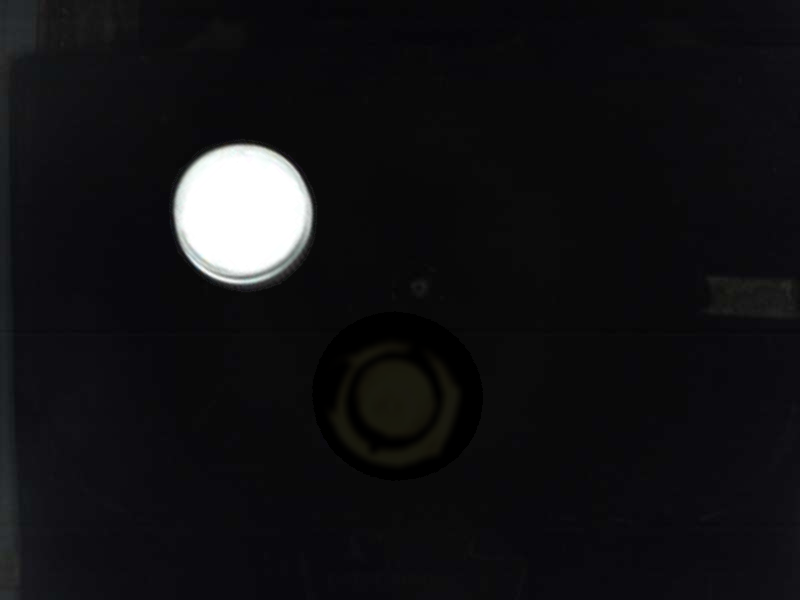

In [24]:
img, df, bin_mask = dataAugm.copy_and_paste(2, rotate=True, change_color=False, make_dark=True)
show_cv(img)

In [13]:
df

,name,count,edge,different colors,one color,transparent,inside,overlapping,dark color,open lid,synthesized
0,synthesized/label_5_img_0.jpg,5,0,NaN,NaN,0,0,1,1,0,1


In [56]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y


def rotate_contour(cnt, angle):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    
    coordinates = cnt_norm[:, 0, :]
    xs, ys = coordinates[:, 0], coordinates[:, 1]
    thetas, rhos = cart2pol(xs, ys)
    
    thetas = np.rad2deg(thetas)
    thetas = (thetas + angle) % 360
    thetas = np.deg2rad(thetas)
    
    xs, ys = pol2cart(thetas, rhos)
    
    cnt_norm[:, 0, 0] = xs
    cnt_norm[:, 0, 1] = ys

    cnt_rotated = cnt_norm + [cx, cy]
    cnt_rotated = cnt_rotated.astype(np.int32)

    return cnt_rotated

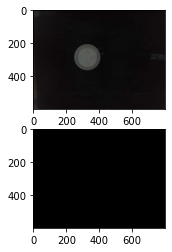

In [21]:
import random
def reduce_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    max_brightness = random.randint(8, 30)
    value = int(max_brightness - np.max(v))
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)    
    return img

a = 1
original_image_a = dataAugm.masks[a].image
new_img = reduce_brightness(original_image_a)
new_img_blur = cv2.blur(original_image_a, (9,9))

plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(original_image_a)
plt.subplot(2, 1, 2) 
plt.imshow(new_img)
#plt.subplot(3, 1, 3) 
#plt.imshow(new_img_blur)
plt.show()

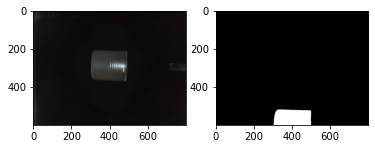

In [10]:
x, y = 400, 600
a = 5
original_image_a = dataAugm.masks[a].image
countur_a = dataAugm.masks[a].cnt
M = cv2.moments(countur_a)
x_a, y_a = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
x_offset, y_offset = x - x_a, y - y_a
mask_a = cv2.drawContours(np.zeros(original_image_a.shape[:2], np.uint8), [countur_a], -1, 255, cv2.FILLED, offset=(x_offset, y_offset))
#countur_rotated = rotate_contour(countur, 90)
#mask_rotated = cv2.drawContours(np.zeros((600, 800), np.uint8), [countur_rotated], -1, 255, cv2.FILLED)

b = 7
original_image_b = dataAugm.masks[b].image
countur_b = dataAugm.masks[b].cnt
mask_b = cv2.drawContours(np.zeros(original_image_b.shape[:2], np.uint8), [countur_b], -1, 255, cv2.FILLED)


mask_combined = cv2.bitwise_and(mask_a, mask_b)
mask_excl = cv2.bitwise_xor(mask_a, mask_combined)

plt.figure()
plt.subplot(1, 2, 1), 
plt.imshow(original_image_a),
plt.subplot(1, 2, 2), 
plt.imshow(mask_a, cmap='gray'),
#plt.subplot(3, 2, 3), 
#plt.imshow(original_image_b),
#plt.subplot(3, 2, 4), 
#plt.imshow(mask_b, cmap='gray'),
#plt.subplot(3, 2, 5), 
#plt.imshow(mask_combined, cmap='gray'),
#plt.subplot(3, 2, 6), 
#plt.imshow(mask_excl, cmap='gray'),
plt.show()